In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "your_id"
#   - kssl v1 mirs: "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG"
#   - kssl v2 mirs: "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT"
#   - seibersdorf mirs: "1-N4pziF8YvMTvUYljVAKLVvayYmf6NeB"
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
!pip install spanda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for brukeropusreader: filename=brukeropusreader-1.3.4-py3-none-any.whl size=5311 sha256=3a398fdd9f6eeaa2e0d78acb4c602575216632dfce34751d55f6044670a7d276
  Stored in directory: /root/.cache/pip/wheels/6a/0d/86/91cddedf53ade4d06446f0efb197520a25ccc18b6725c65378
Successfully built brukeropusreader


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
                                    AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, GADFTfm,
                                    ResizeTfm, LogTfm)

import warnings
warnings.filterwarnings('ignore')

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

analyte_name = 725

In [ ]:
# Only samples with spectra
path = Path('../../../_data/kssl-mirs-v2'); path.ls()

(#46305) [Path('../../../_data/kssl-mirs-v2/180338'),Path('../../../_data/kssl-mirs-v2/172221'),Path('../../../_data/kssl-mirs-v2/177753'),Path('../../../_data/kssl-mirs-v2/184798'),Path('../../../_data/kssl-mirs-v2/53759'),Path('../../../_data/kssl-mirs-v2/74947'),Path('../../../_data/kssl-mirs-v2/176681'),Path('../../../_data/kssl-mirs-v2/1855'),Path('../../../_data/kssl-mirs-v2/175004'),Path('../../../_data/kssl-mirs-v2/34499')...]

In [ ]:
# keep only when spectra in folder
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|███████████████████████████████████████████████████████| 46305/46305 [00:01<00:00, 26133.23it/s]

n samples: 46251


In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
# Only pos. measurements
paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

100%|████████████████████████████████████████████████████████| 46251/46251 [00:34<00:00, 1350.82it/s]

n samples: 44565


In [ ]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[AvgTfm, GADFTfm, ResizeTfm,
                              LogTfm],
    )

dls = dblock.dataloaders(paths[:n_smp], bs=64, num_workers=8)
#dls.show_batch()

In [ ]:
def dl_time_per_epoch(t, n=40000, bs=32):
    dl_time = t*n/(bs*60)
    print(f'about {dl_time:.3} min per epoch')

In [ ]:
durations = []
n_batches = 10
i = 0
for x, y in dls.train:
    if i > 0: 
        duration = time.time() - start
        print(f'{duration} s per batch')
        durations.append(duration)
        
    if i > n_batches: break
    start = time.time()
    i += 1
    
print(f'on average: {np.array(durations).mean():.3} s per batch')
dl_time_per_epoch(np.array(durations).mean(), bs=64)

0.7630250453948975 s per batch
0.7463290691375732 s per batch
0.7622542381286621 s per batch
0.7351529598236084 s per batch
0.7457771301269531 s per batch
0.76755690574646 s per batch
0.7589709758758545 s per batch
0.7467646598815918 s per batch
0.7568578720092773 s per batch
0.7533700466156006 s per batch
0.7253236770629883 s per batch
on average: 0.751 s per batch
about 7.82 min per epoch


In [ ]:
dls.one_batch()[0][0].shape

torch.Size([1, 256, 256])

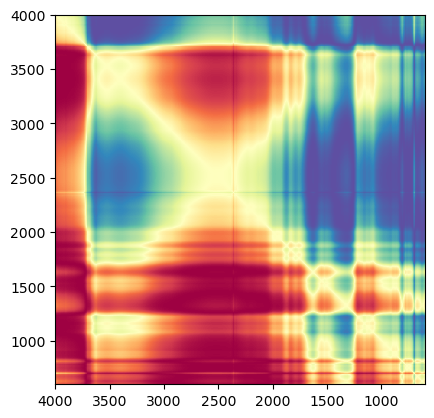

In [ ]:
plt.imshow(dls.one_batch()[0][0].squeeze().cpu(), cmap='Spectral', 
           origin='upper', extent=[4000,600,600,4000]);

In [ ]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 1 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.00363078061491251)

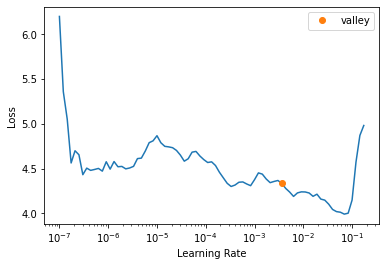

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,r2_score,time
0,0.166571,0.126924,0.449126,04:06


epoch,train_loss,valid_loss,r2_score,time
0,0.091450,0.076357,0.668597,04:08
1,0.089020,0.072632,0.684763,04:09
2,0.082323,0.066123,0.713013,04:09
3,0.071892,0.087353,0.620871,04:09
4,0.066847,0.055563,0.758845,04:09
5,0.055346,0.056796,0.753495,04:08
6,0.050615,0.046505,0.798160,04:09
7,0.034366,0.043906,0.809439,04:07
8,0.031474,0.042635,0.814954,04:08
9,0.025054,0.042423,0.815875,04:10


In [ ]:
learn.save('xresnet18-kex-mirs-kssl-10-epochs-gadf-dl-07052023')

Path('models/xresnet18-kex-mirs-kssl-10-epochs-gadf-07052023.pth')